In [1]:
!pip install --upgrade pip

!pip install --quiet diffusers transformers accelerate torch torchvision torchaudio ftfy
!pip install --quiet git+https://github.com/openai/CLIP.git
!pip install --quiet scipy pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 134.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 M

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


# 폴더 준비
os.makedirs("outputs", exist_ok=True)

In [3]:
from google.colab import files
uploaded = files.upload()  # → prompt_list.csv 업로드

Saving prompt_list.csv to prompt_list.csv


In [4]:
# STEP 2: 프롬프트 리스트

import pandas as pd

prompt_df = pd.read_csv("prompt_list.csv")
prompt_df.head()

,prompt_id,prompt_text,category,length,has_style,has_negative
0,S1,a cat,Simple,2,False,False
1,S2,a car,Simple,2,False,False
2,S3,a tree,Simple,2,False,False
3,S4,a mountain,Simple,2,False,False
4,S5,a person,Simple,2,False,False


In [5]:
# STEP 3: Stable Diffusion 이미지 생성 함수 (v2.1)

from diffusers import StableDiffusionPipeline
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Stable Diffusion v2.1
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    revision="fp16",
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)

# CLIP (for semantic similarity)
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/517 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:242: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-1/snapshots/f7f33030acc57428be85fbec092c37a78231d75a/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 59.1MiB/s]


In [6]:
# STEP 4: CLIP 유사도 측정 함수
@torch.no_grad()
def generate_image_and_latent(prompt, save_path):
    output = pipe(prompt, return_dict=True, guidance_scale=7.5)

    # 저장
    image = output.images[0]
    image.save(save_path)

    # Latent 추출: text encoder의 마지막 hidden state 평균
    input_ids = pipe.tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    text_outputs = pipe.text_encoder(input_ids)
    text_embedding = text_outputs.last_hidden_state.mean(dim=1)  # [batch_size, hidden_size]

    return text_embedding.squeeze().cpu().numpy()

In [7]:
# STEP 5: CLIP similarity 계산 함수
@torch.no_grad()
def compute_clip_similarity(prompt, image_path):
    image = Image.open(image_path).convert("RGB")
    image_input = clip_preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([prompt]).to(device)

    image_features = clip_model.encode_image(image_input)
    text_features = clip_model.encode_text(text_input)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = (image_features @ text_features.T).item()
    return similarity


In [9]:
# STEP 5: 실험 루프 실행

results = []

for idx, row in tqdm(prompt_df.iterrows(), total=len(prompt_df)):
    prompt = row["prompt_text"]
    pid = row["prompt_id"]
    img_path = f"outputs/{pid}.png"

    latent = generate_image_and_latent(prompt, img_path)
    clip_score = compute_clip_similarity(prompt, img_path)

    results.append({
        "prompt_id": pid,
        "prompt": prompt,
        "category": row["category"],
        "prompt_length": row["length"],
        "has_style": row["has_style"],
        "has_negative": row["has_negative"],
        "image_path": img_path,
        "clip_score": clip_score,
        "latent_vector": latent
    })

df_result = pd.DataFrame(results)
df_result.to_pickle("clip_latent_results.pkl")
df_result.to_csv("clip_latent_results.csv", index=False)
df_result[["prompt_id", "prompt", "clip_score"]].head()


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:19<07:54, 19.76s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  8%|▊         | 2/25 [00:38<07:15, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 12%|█▏        | 3/25 [00:57<07:00, 19.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 16%|█▌        | 4/25 [01:17<06:49, 19.52s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 20%|██        | 5/25 [01:36<06:26, 19.33s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 24%|██▍       | 6/25 [01:55<06:02, 19.10s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 28%|██▊       | 7/25 [02:13<05:41, 18.99s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 32%|███▏      | 8/25 [02:33<05:23, 19.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 36%|███▌      | 9/25 [02:52<05:04, 19.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 40%|████      | 10/25 [03:11<04:45, 19.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|████▍     | 11/25 [03:30<04:25, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 48%|████▊     | 12/25 [03:48<04:06, 18.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 52%|█████▏    | 13/25 [04:07<03:47, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 56%|█████▌    | 14/25 [04:26<03:28, 18.99s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|██████    | 15/25 [04:45<03:09, 18.97s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 64%|██████▍   | 16/25 [05:04<02:50, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 68%|██████▊   | 17/25 [05:23<02:31, 18.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 72%|███████▏  | 18/25 [05:42<02:12, 18.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 76%|███████▌  | 19/25 [06:01<01:53, 18.99s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 80%|████████  | 20/25 [06:20<01:35, 19.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 84%|████████▍ | 21/25 [06:39<01:16, 19.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 88%|████████▊ | 22/25 [06:59<00:57, 19.05s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 92%|█████████▏| 23/25 [07:17<00:38, 19.02s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 96%|█████████▌| 24/25 [07:37<00:19, 19.03s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 25/25 [07:56<00:00, 19.04s/it]


,prompt_id,prompt,clip_score
0,S1,a cat,0.263672
1,S2,a car,0.262939
2,S3,a tree,0.281250
3,S4,a mountain,0.291748
4,S5,a person,0.261963


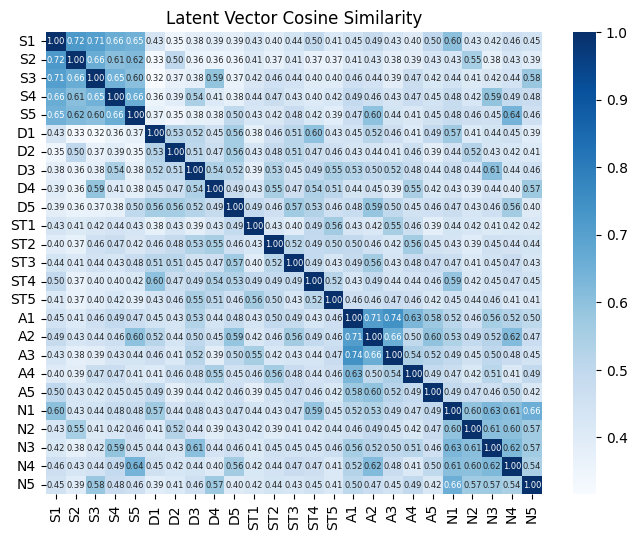

In [14]:
# STEP 7: Latent 간 cosine similarity + 시각화 준비

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# latent vector matrix
latent_matrix = np.stack(df_result["latent_vector"].values)
prompt_ids = df_result["prompt_id"].tolist()

# cosine 유사도 행렬
cos_sim_matrix = cosine_similarity(latent_matrix)

# heatmap 시각화
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(
    cos_sim_matrix,
    xticklabels=prompt_ids,
    yticklabels=prompt_ids,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    annot_kws={"size": 6}
  )
plt.title("Latent Vector Cosine Similarity")
plt.show()

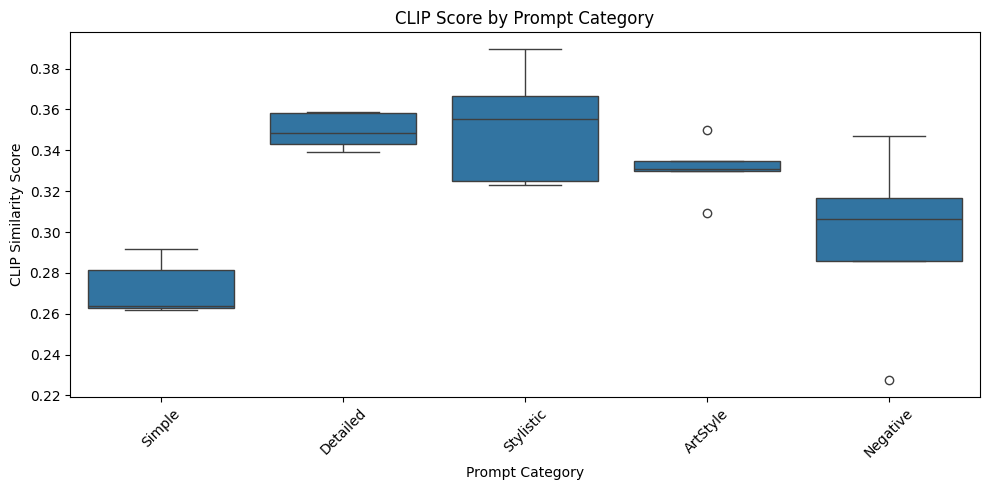

In [11]:
# Optional: ensure data types for correct grouping
df_result["has_style"] = df_result["has_style"].astype(bool)
df_result["has_negative"] = df_result["has_negative"].astype(bool)

# Boxplot: CLIP score by prompt category
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_result, x="category", y="clip_score")
plt.title("CLIP Score by Prompt Category")
plt.xlabel("Prompt Category")
plt.ylabel("CLIP Similarity Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

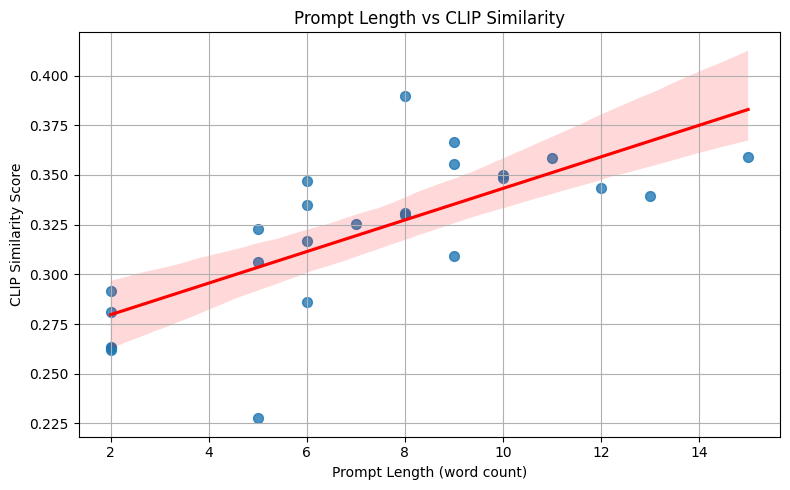

In [15]:
# Prompt length vs CLIP similarity scatter plot
plt.figure(figsize=(8, 5))
sns.regplot(data=df_result, x="prompt_length", y="clip_score", scatter_kws={"s": 50}, line_kws={"color": "red"})
plt.title("Prompt Length vs CLIP Similarity")
plt.xlabel("Prompt Length (word count)")
plt.ylabel("CLIP Similarity Score")
plt.grid(True)
plt.tight_layout()
plt.show()

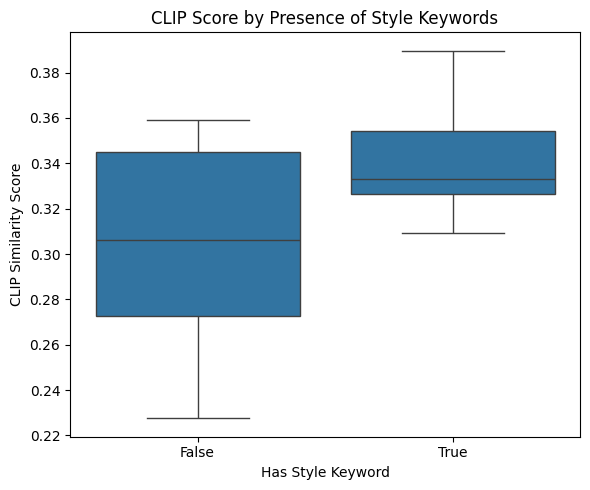

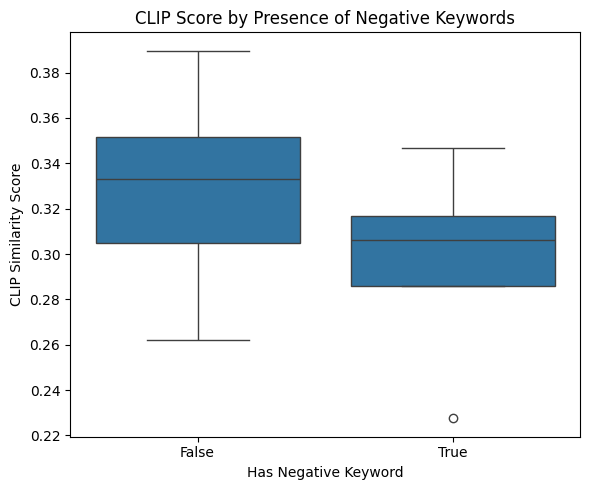

In [16]:
# has_style vs CLIP score
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_result, x="has_style", y="clip_score")
plt.title("CLIP Score by Presence of Style Keywords")
plt.xlabel("Has Style Keyword")
plt.ylabel("CLIP Similarity Score")
plt.tight_layout()
plt.show()

# has_negative vs CLIP score
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_result, x="has_negative", y="clip_score")
plt.title("CLIP Score by Presence of Negative Keywords")
plt.xlabel("Has Negative Keyword")
plt.ylabel("CLIP Similarity Score")
plt.tight_layout()
plt.show()

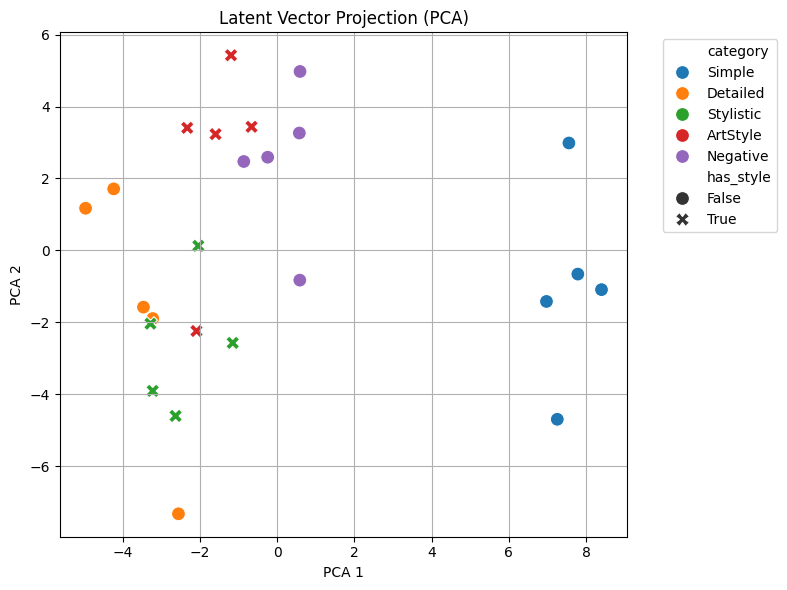

In [17]:
from sklearn.decomposition import PCA
import numpy as np

# Convert latent_vector string → list if needed
if isinstance(df_result["latent_vector"].iloc[0], str):
    df_result["latent_vector"] = df_result["latent_vector"].apply(eval)

# latent vectors to matrix
latent_matrix = np.stack(df_result["latent_vector"].values)

# PCA to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_matrix)

# Attach to dataframe
df_result["pca_x"] = latent_2d[:, 0]
df_result["pca_y"] = latent_2d[:, 1]

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_result, x="pca_x", y="pca_y", hue="category", style="has_style", s=100)
plt.title("Latent Vector Projection (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

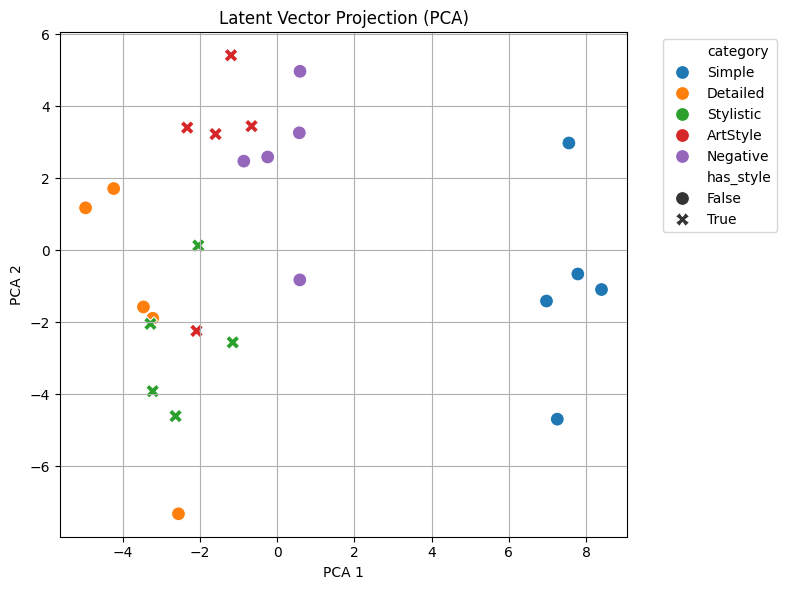

In [24]:
# Perform PCA
latent_matrix = []
for result in results:
  latent_matrix.append(result['latent_vector'])

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_matrix)

# Add PCA coordinates to dataframe
df_result["pca_x"] = latent_2d[:, 0]
df_result["pca_y"] = latent_2d[:, 1]

# Plot PCA projection of latent vectors
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_result, x="pca_x", y="pca_y", hue="category", style="has_style", s=100)
plt.title("Latent Vector Projection (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

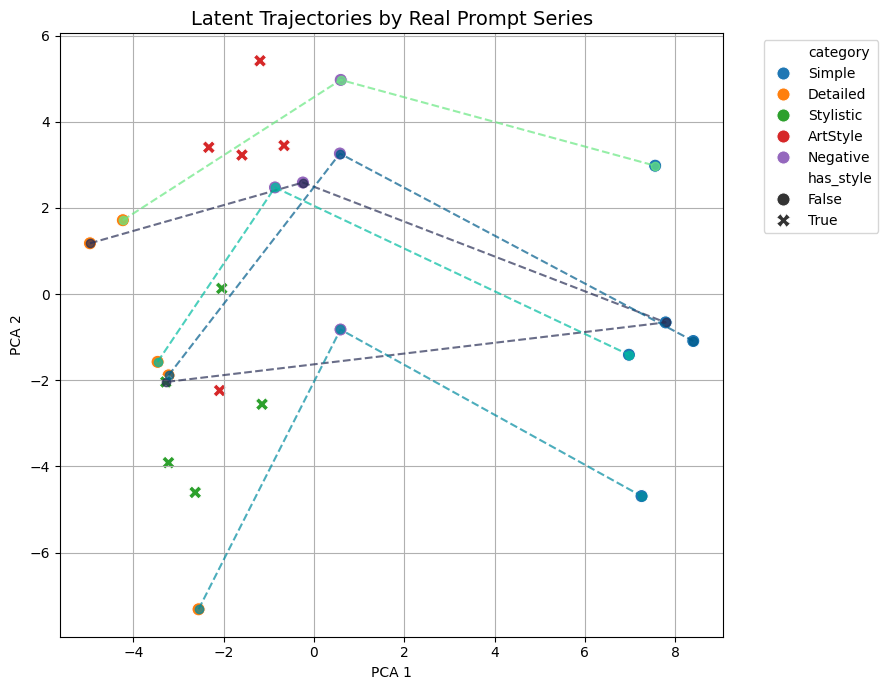

In [28]:
actual_series_groups = [
    ["S1", "D1", "ST4", "N1"],  # Cat series
    ["S2", "D2", "N2"],         # Car series
    ["S3", "D4", "N5"],         # Tree series
    ["S4", "D3", "N3"],         # Mountain series
    ["S5", "D5", "N4"],         # Person series
]

colors = ['#292f56', '#005c8b', '#008ba0', '#00bca1', '#69e882']

# Plot PCA points and connect new series
plt.figure(figsize=(9, 7))

# All points
sns.scatterplot(data=df_result, x="pca_x", y="pca_y", hue="category", style="has_style", s=90)

# Overlay real series group connections
for i, series in enumerate(actual_series_groups):
    subset = df_result[df_result["prompt_id"].isin(series)].sort_values("prompt_id")
    if len(subset) >= 2:
        plt.plot(subset["pca_x"], subset["pca_y"], marker='o', linestyle='--', color=colors[i], alpha=0.7)

plt.title("Latent Trajectories by Real Prompt Series", fontsize=14)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

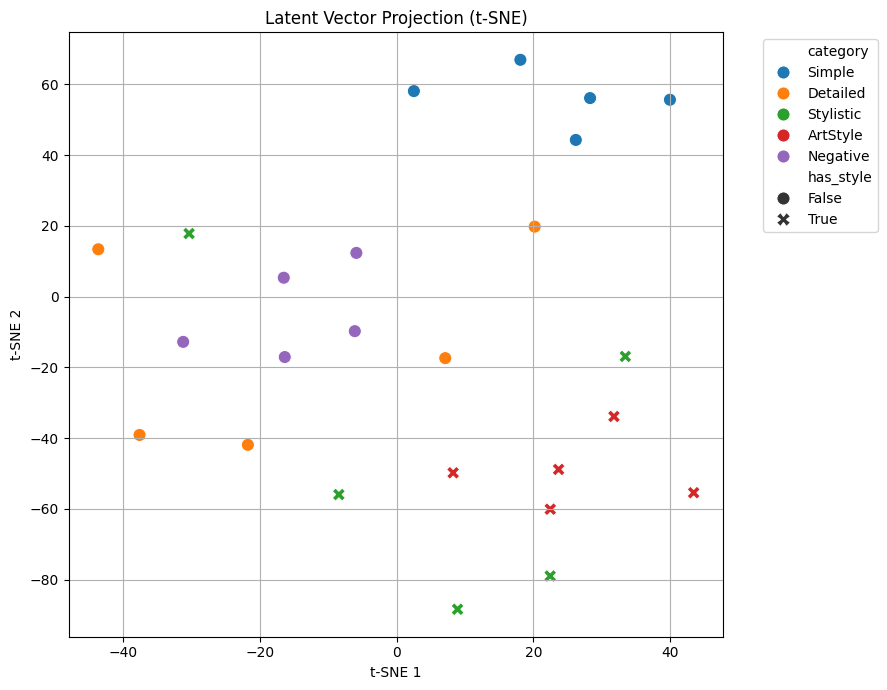

In [30]:
# Run t-SNE on the latent vectors
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
latent_2d_tsne = tsne.fit_transform(np.array(latent_matrix))

# Add t-SNE coordinates to dataframe
df_result["tsne_x"] = latent_2d_tsne[:, 0]
df_result["tsne_y"] = latent_2d_tsne[:, 1]

# Plot t-SNE
plt.figure(figsize=(9, 7))
sns.scatterplot(data=df_result, x="tsne_x", y="tsne_y", hue="category", style="has_style", s=90)
plt.title("Latent Vector Projection (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

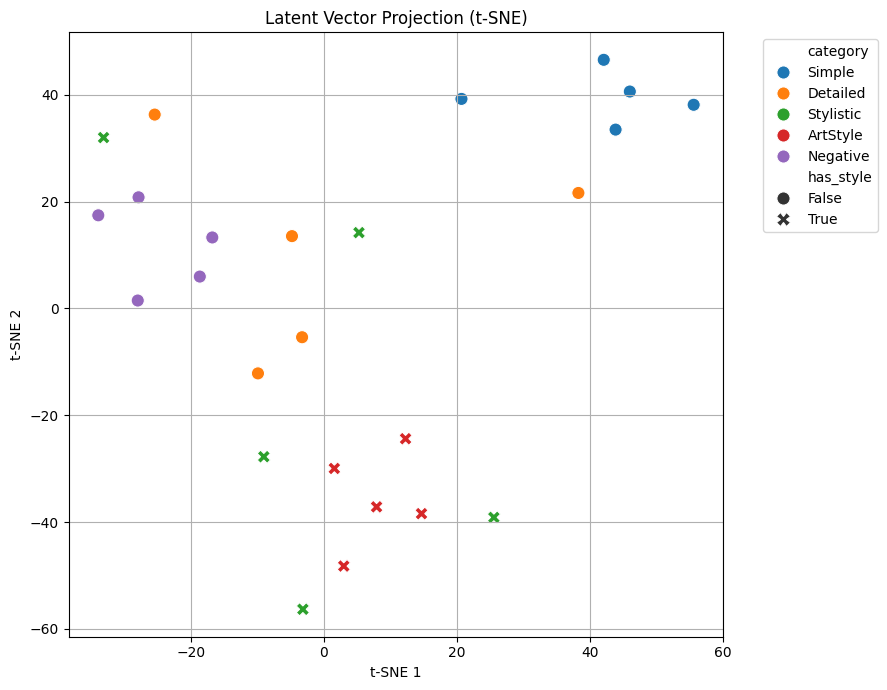

In [32]:
# Retry t-SNE with faster settings
from sklearn.manifold import TSNE

# Faster t-SNE configuration for small datasets
tsne = TSNE(
    n_components=2,
    perplexity=3,
    max_iter=500,
    init="pca",
    learning_rate="auto",
    random_state=42
)
latent_2d_tsne = tsne.fit_transform(np.array(latent_matrix))

# Add t-SNE coordinates to dataframe
df_result["tsne_x"] = latent_2d_tsne[:, 0]
df_result["tsne_y"] = latent_2d_tsne[:, 1]

# Plot t-SNE
plt.figure(figsize=(9, 7))
sns.scatterplot(data=df_result, x="tsne_x", y="tsne_y", hue="category", style="has_style", s=90)
plt.title("Latent Vector Projection (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


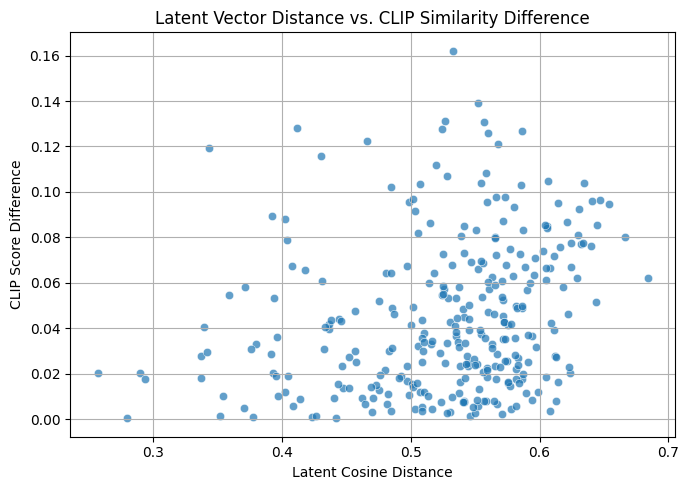

(np.float64(0.2361535084689699), np.float64(3.59915186844312e-05))

In [36]:
from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import pearsonr
import itertools

# 준비: prompt pair 조합 생성
df_result = df_result.sort_values("prompt_id").reset_index(drop=True)
prompt_pairs = list(itertools.combinations(df_result.index, 2))

# 거리와 점수 차이 저장
records = []

for i, j in prompt_pairs:
    pid_i, pid_j = df_result.loc[i, "prompt_id"], df_result.loc[j, "prompt_id"]

    latent_i = df_result.loc[i, "latent_vector"]
    latent_j = df_result.loc[j, "latent_vector"]
    dist_latent = cosine_distances([latent_i], [latent_j])[0][0]

    clip_i = df_result.loc[i, "clip_score"]
    clip_j = df_result.loc[j, "clip_score"]
    diff_clip = abs(clip_i - clip_j)

    records.append({
        "prompt_id_1": pid_i,
        "prompt_id_2": pid_j,
        "latent_distance": dist_latent,
        "clip_diff": diff_clip
    })

df_corr = pd.DataFrame(records)

# 산점도 시각화
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_corr, x="latent_distance", y="clip_diff", alpha=0.7)
plt.title("Latent Vector Distance vs. CLIP Similarity Difference")
plt.xlabel("Latent Cosine Distance")
plt.ylabel("CLIP Score Difference")
plt.grid(True)
plt.tight_layout()
plt.show()

# 상관계수 계산
corr_coef, p_value = pearsonr(df_corr["latent_distance"], df_corr["clip_diff"])
corr_coef, p_value

In [35]:
df_result['latent_vector']

,latent_vector
0,"[-0.509, -0.637, -0.06287, 0.344, -0.04382, -0..."
1,"[-1.083, -0.647, 0.2245, -0.01563, -0.03894, -..."
2,"[-0.537, -0.8145, -0.459, 0.2336, 0.1427, -0.2..."
3,"[-0.3914, -0.853, -0.819, -0.10876, 0.06964, 0..."
4,"[0.1381, -0.587, -0.3845, 0.1398, 0.0903, 0.08..."
5,"[-0.3633, -0.05032, 0.1368, 0.1365, 0.4773, -0..."
6,"[-0.3936, -0.4775, -0.663, -0.1522, 0.26, -0.2..."
7,"[-0.785, -0.8945, -0.2434, -0.1649, 0.125, -0...."
8,"[-1.096, -0.6025, -0.3313, -0.136, -0.06287, -..."
9,"[-0.6924, -0.415, -0.1641, -0.1716, 0.1522, -0..."
